# Анализ сервиса службы поддержки

Практическое задание:

   1) Посчитать:  
    а) количество новых тикетов за каждый месяц;  
    б) SLA за каждый месяц.  

   2) Построить графики:  
    а) количество за весь период в динамике;  
    б) SLA за весь период в динамике.  

   3) Проанализировать:  
    а) как ведёт себя количество тикетов в течение года;  
    б) сравнить между собой 2022, 2023 и 2024 гг;  
    в) корреляцию между нагрузкой и SLA.  

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

*Примечание: файл с данными должен находится в одной папке с тетрадкой для корректной работы*

In [7]:
data_sla = pd.read_excel('trial.xlsx',engine='openpyxl', sheet_name='SLA')

In [8]:
data_oper = pd.read_excel('trial.xlsx',engine='openpyxl', sheet_name='oper')

## Обзор данных

In [10]:
def data_overview(df):
    print("Общая информация:")
    print(df.info())
    print("\n Первые 5 строк данных:")
    print(df.head())
    print("\n Размерность датафрейма:")
    print(f"Строк: {df.shape[0]}, Колонок: {df.shape[1]}")
    print("\n Статистика по числовым признакам:")
    print(df.describe().round(2))
    print("\n Количество пропущенных значений по колонкам:")
    print(df.isnull().sum())
    print("\n Уникальные значения по колонкам:")
    for col in df.columns:
        unique_vals = df[col].nunique()
        print(f" столбец:{col}, кол-во уникальных значений: {unique_vals}")

In [11]:
data_overview(data_sla)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282981 entries, 0 to 282980
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Дата создания тикета  282981 non-null  datetime64[ns]
 1   Количество тикетов    282981 non-null  int64         
 2   СЛА                   282981 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.5 MB
None

 Первые 5 строк данных:
  Дата создания тикета  Количество тикетов  СЛА
0  2022-01-01 06:33:34                   1  0.0
1  2022-01-01 08:14:39                   1  1.0
2  2022-01-01 09:00:31                   1  1.0
3  2022-01-01 09:24:38                   1  1.0
4  2022-01-01 09:49:39                   1  1.0

 Размерность датафрейма:
Строк: 282981, Колонок: 3

 Статистика по числовым признакам:
                Дата создания тикета  Количество тикетов        СЛА
count                         2829

In [12]:
data_overview(data_oper)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Оператор            140 non-null    object        
 1   Месяц               140 non-null    datetime64[ns]
 2   Обработано тикетов  140 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.4+ KB
None

 Первые 5 строк данных:
  Оператор      Месяц  Обработано тикетов
0     Катя 2024-10-01                1005
1     Катя 2024-11-01                 803
2     Катя 2024-12-01                 619
3     Лёша 2024-01-01                 395
4     Лёша 2024-02-01                 500

 Размерность датафрейма:
Строк: 140, Колонок: 3

 Статистика по числовым признакам:
                               Месяц  Обработано тикетов
count                            140              140.00
mean   2024-07-03 22:58:17.142857216            

**Вывод:**  
Необходимо переименовать столбцы в корректный и удобный для работы вид. Дополнительная манипуляции по предобработке данных не требуются.

## Предобработка

Выполним переименования столбцов в корректный вид

In [16]:
data_sla.columns = ['date_creation','total_tickets','sla']
data_sla.head()

,date_creation,total_tickets,sla
0,2022-01-01 06:33:34,1,0.0
1,2022-01-01 08:14:39,1,1.0
2,2022-01-01 09:00:31,1,1.0
3,2022-01-01 09:24:38,1,1.0
4,2022-01-01 09:49:39,1,1.0


In [17]:
data_oper.columns = ['name','month','tickets_done']
data_oper.head()

,name,month,tickets_done
0,Катя,2024-10-01,1005
1,Катя,2024-11-01,803
2,Катя,2024-12-01,619
3,Лёша,2024-01-01,395
4,Лёша,2024-02-01,500


## Задание 1  

Посчитать:  
    а) количество новых тикетов за каждый месяц;  
    б) SLA за каждый месяц. 

Добавим столбцы с годом и номером месяца

In [21]:
data_sla['year'] = data_sla['date_creation'].dt.year

In [22]:
data_sla['month'] = data_sla['date_creation'].dt.month

In [23]:
data_sla.head()

,date_creation,total_tickets,sla,year,month
0,2022-01-01 06:33:34,1,0.0,2022,1
1,2022-01-01 08:14:39,1,1.0,2022,1
2,2022-01-01 09:00:31,1,1.0,2022,1
3,2022-01-01 09:24:38,1,1.0,2022,1
4,2022-01-01 09:49:39,1,1.0,2022,1


Построим сводную таблицу с данными необходимыми по заданию 1

In [90]:
pivot_sla =  data_sla.groupby(['year','month']).agg({
            'total_tickets':'sum', 'sla':'mean'
            })
pivot_sla['sla'] = pivot_sla['sla'].round(2)
pivot_sla

total_tickets   sla
year month                     
2022 1               4683  0.91
     2               6141  0.89
     3               6740  0.54
     4               6674  0.76
     5               5619  0.89
     6               5060  0.91
     7               4035  0.80
     8               4067  0.84
     9               4694  0.77
     10              5842  0.31
     11              7054  0.20
     12              4703  0.27
2023 1               4056  0.67
     2               3850  0.85
     3               5566  0.67
     4               4843  0.63
     5               5427  0.72
     6               5787  0.40
     7               7360  0.59
     8               9601  0.27
     9              13994  0.49
     10             15893  0.56
     11             13293  0.57
     12             16405  0.77
2024 1              12606  0.95
     2              15183  0.95
     3              14135  0.90
     4              12213  0.92
     5               8463  0.94
     6               6956  0.92
     7               8654  0.83
     8               9440  0.86
     9               9059  0.83
     10              9416  0.74
     11              8281  0.87
     12              6072  0.99

Отобразим в отдельных переменных изменения за каждый год, выполним сортировку по количеству тикетов по убыванию

In [27]:
tickets_2022 = pivot_sla.query('year==2022').sort_values(by='total_tickets',ascending=False)
tickets_2022

total_tickets   sla
year month                     
2022 11              7054  0.20
     3               6740  0.54
     4               6674  0.76
     2               6141  0.89
     10              5842  0.31
     5               5619  0.89
     6               5060  0.91
     12              4703  0.27
     9               4694  0.77
     1               4683  0.91
     8               4067  0.84
     7               4035  0.80

In [28]:
tickets_2023 = pivot_sla.query('year==2023').sort_values(by='total_tickets',ascending=False)
tickets_2023

total_tickets   sla
year month                     
2023 12             16405  0.77
     10             15893  0.56
     9              13994  0.49
     11             13293  0.57
     8               9601  0.27
     7               7360  0.59
     6               5787  0.40
     3               5566  0.67
     5               5427  0.72
     4               4843  0.63
     1               4056  0.67
     2               3850  0.85

In [29]:
tickets_2024 = pivot_sla.query('year==2024').sort_values(by='total_tickets',ascending=False)
tickets_2024

total_tickets   sla
year month                     
2024 2              15183  0.95
     3              14135  0.90
     1              12606  0.95
     4              12213  0.92
     8               9440  0.86
     10              9416  0.74
     9               9059  0.83
     7               8654  0.83
     5               8463  0.94
     11              8281  0.87
     6               6956  0.92
     12              6072  0.99

## Задание 2

Построить графики:  
    а) количество за весь период в динамике;  
    б) SLA за весь период в динамике.

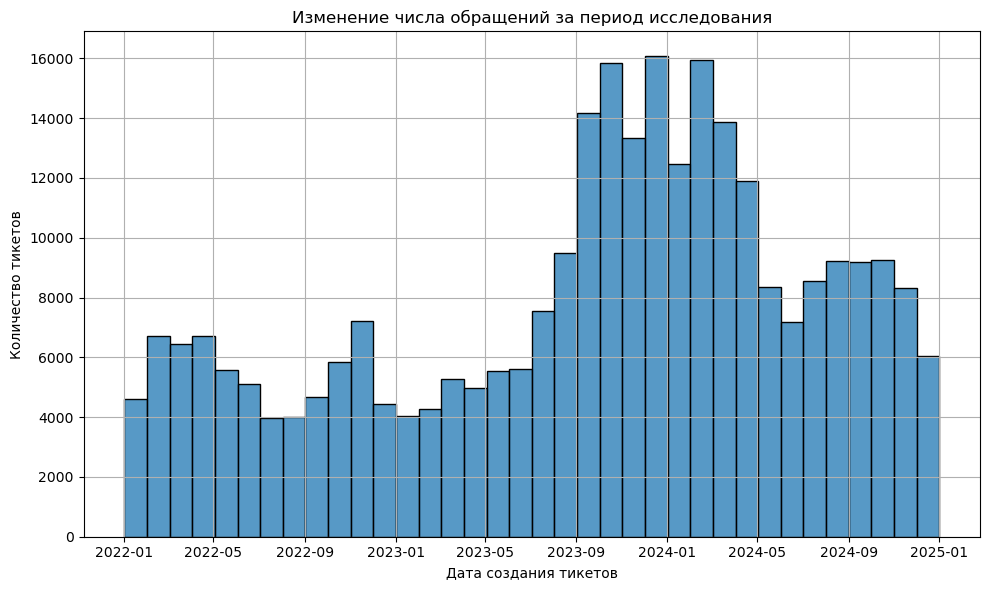

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_sla, x='date_creation', weights='total_tickets', bins=36)
plt.title('Изменение числа обращений за период исследования')
plt.xlabel('Дата создания тикетов')
plt.ylabel('Количество тикетов')
plt.grid(True)
plt.tight_layout()
plt.show()

Из графика видно, что в 2022 году было меньше всего тикетов, больше всего обращений было в конце 2023 года и первой трети 2024 года.

Для оптимизации построения графика SLA в динамике, отбросим время в столбце с датой. Значения SLA расчитаем как среднее, если в какой-то день было больше одного обращения.

In [35]:
data_sla['date'] = data_sla['date_creation'].dt.date
daily_sla = data_sla.groupby('date').agg({'sla': 'mean'}).reset_index().round(3)
daily_sla

,date,sla
0,2022-01-01,0.814
1,2022-01-02,0.958
2,2022-01-03,1.000
3,2022-01-04,0.983
4,2022-01-05,1.000
...,...,...
1091,2024-12-27,0.984
1092,2024-12-28,1.000
1093,2024-12-29,0.992
1094,2024-12-30,0.995


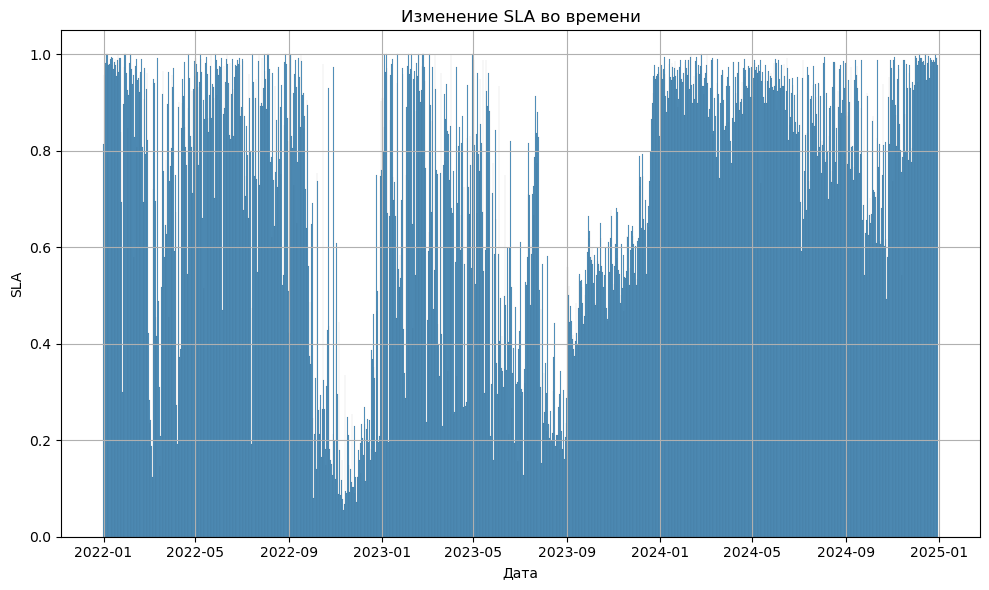

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=daily_sla, x='date', weights='sla')
plt.title('Изменение SLA во времени')
plt.xlabel('Дата')
plt.ylabel('SLA')
plt.grid(True)
plt.tight_layout()
plt.show()

Как видно из графика, регулярное и сильное снижение SLA ниже допустимого происходило в конце 2022 года , а также во второй половине 2023 года. Но в 2024 году уровень SLA стабильнее. Имеется просадка в диапазон 0.6-0.8 в период высокой нагрузке с осени 2024 года. в целом

## Задание 3

Проанализировать:  
    а) как ведёт себя количество тикетов в течение года;  
    б) сравнить между собой 2022, 2023 и 2024 гг;  
    в) корреляцию между нагрузкой и SLA.

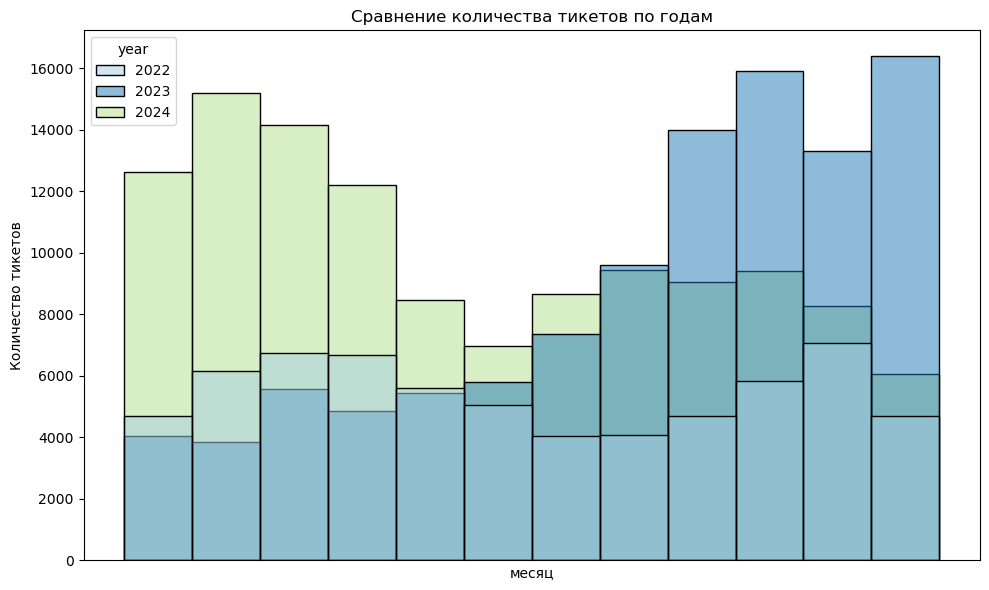

In [40]:
plt.figure(figsize=(10,6))
ax=sns.histplot(data = pivot_sla, x='month',weights='total_tickets',hue='year',bins=12, multiple='layer',element='bars',palette='Paired', common_norm=False)
plt.xticks([])
plt.title('Сравнение количества тикетов по годам')
plt.xlabel('месяц')
plt.ylabel('Количество тикетов')
plt.tight_layout()
plt.show()

В 2022 году было меньше всего тикетов (4-7 тыс в месяц).
Большего всего обращений (12-16 тыс в месяц) было в последюю треть  2023 года и первую треть 2024 года.  
До конца 2024 года идет спад по количеству обращений (6-9 тыс в месяц). Но их количество больше, чем в аналогичный период .  
В 2022 году количество обращений снижалось в середине года, но в начале и конце были на одном уровне.
В 2023 году количество обращений с начала года постепенно растет, во второй половине года их количество стремительно увеличивается и к концу года их становится более чем в 3 раза больше чем в начале года.
В 2024 году количество тикетов сохраняется на высоком уровне к маю месяцу снижается до уровня в ~8000 обращений в месяц, но нет роста числа обращений по отношению к началу года, как в предыдущие года.

Приведем столбец `month` к виду как в таблице `pivot_sla`

In [72]:
data_oper['month'] = data_oper['month'].dt.month

Выведем данные по нагрузке по месяцам из данных `data_oper`

In [80]:
pivot_oper =  data_oper.groupby(['month']).agg({
            'tickets_done':'sum'})
pivot_oper.sort_values(by='tickets_done',ascending=False)

,tickets_done
month,
10,20105
11,18711
9,17042
8,15328
12,15298
7,13881
4,12278
6,11891
5,10177


Объединим таблицы `tickets_2024` и `pivot_oper`. Так как данные в датафрейме `data_oper` представлены только за 2024 год

In [88]:
merged = pd.merge(tickets_2024, pivot_oper, on='month', how='inner')
merged

,total_tickets,sla,tickets_done
month,,,
2,15183,0.95,6462
3,14135,0.90,8795
1,12606,0.95,6000
4,12213,0.92,12278
8,9440,0.86,15328
10,9416,0.74,20105
9,9059,0.83,17042
7,8654,0.83,13881
5,8463,0.94,10177


Определим коэффециент корреляции Пирсона (статистическое измерение линейной зависимости) между параметрами `sla` и `tickets_done`

In [99]:
correlation = merged['sla'].corr(merged['tickets_done'])
print("Коэффициент корреляции:", correlation)

Коэффициент корреляции: -0.6802893189076259


Интерпретируя полученный результат по шкале Чеддока, можно сказать что между величинами заметная средняя обратнопропорциональная связь, то есть при росте одной велечины другая уменьшается, что имеет определенную логику. При меньшем количестве обработанных тикетов, качество улучшается следовательно SLA высокий.